In [9]:
# ===============================
# 1) Imports & Global Setup
# ===============================
import os
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from collections import deque
from itertools import product

# Device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("DEVICE:", DEVICE)

# Grid
NX, NY = 64, 148
L = NX * NY

# Paths
MODEL_PATH = "./Irreversible_Sorption.pt"   # trained weights
DOMAIN_PATH = "./Domain_Irreversible_Sorption.npz"                   # raw domain (flat length=9472), reshape to (64,148)
assert os.path.exists(MODEL_PATH), f"Not found: {MODEL_PATH}"
assert os.path.exists(DOMAIN_PATH), f"Not found: {DOMAIN_PATH}"

# Physics conditions (9 combos)
PE_VALUES  = (1.0, 5.0, 10.0)               # Pe
DAA_VALUES = (74.0, 296.0, 740.0)           # Da_A

# Normalization ranges used in training
PE_MIN,  PE_MAX  = 1.0, 10.0
DA_MIN,  DA_MAX  = 74.0, 740.0

def normalize_pe_da(pe, da):
    """Map raw (pe, da) to [0,1] based on training min/max."""
    pe_n = (float(pe) - PE_MIN) / (PE_MAX - PE_MIN)
    da_n = (float(da) - DA_MIN) / (DA_MAX - DA_MIN)
    return pe_n, da_n


DEVICE: cpu


In [11]:
# ===============================
# 2) Compute GDF from domain (inlet-high, solid=0) & quick visualization
# ===============================
def boundary_distance_map(m_bin, boundary='inlet'):
    """
    4-neighbor geodesic distance through pores (1), starting from inlet(y=0) or outlet(y=ny-1).
    Seeds have distance 0.5; each pore step adds 1.0. Solids (0) are never visited.
    """
    nx, ny = m_bin.shape
    dist_map = np.zeros_like(m_bin, dtype=np.float32)

    if boundary == 'inlet':
        starts = [(i, 0) for i in range(nx) if m_bin[i, 0] == 1]
    else:
        starts = [(i, ny - 1) for i in range(nx) if m_bin[i, ny - 1] == 1]

    q = deque()
    for (x, y) in starts:
        dist_map[x, y] = 0.5
        q.append((x, y))

    # BFS on pores
    for_x = [-1, 1, 0, 0]
    for_y = [0, 0, -1, 1]
    while q:
        x, y = q.popleft()
        for dx, dy in zip(for_x, for_y):
            xx, yy = x + dx, y + dy
            if 0 <= xx < nx and 0 <= yy < ny and m_bin[xx, yy] == 1:
                new_dist = dist_map[x, y] + 1.0
                if dist_map[xx, yy] == 0 or dist_map[xx, yy] > new_dist:
                    dist_map[xx, yy] = new_dist
                    q.append((xx, yy))
    return dist_map

def make_inlet_distance_norm(m_bin):
    """
    Build GDF in [0,1] such that:
      * near inlet -> high (~1), far from inlet -> low (~0)
      * solids (0) -> 0
    """
    dist_inlet = boundary_distance_map(m_bin, boundary='inlet')
    if (m_bin == 1).any():
        max_val = float(np.nanmax(dist_inlet[m_bin == 1]))
    else:
        max_val = 0.0
    dist_inlet[m_bin == 0] = max_val + 1.0
    dist_inlet = -dist_inlet  # inlet-high after normalization

    gdf = np.zeros_like(dist_inlet, dtype=np.float32)
    valid = (m_bin == 1) & np.isfinite(dist_inlet)
    if np.any(valid):
        vmin = float(dist_inlet[valid].min())
        vmax = float(dist_inlet[valid].max())
        if vmax > vmin:
            gdf[valid] = (dist_inlet[valid] - vmin) / (vmax - vmin)
        else:
            gdf[valid] = 1.0
    gdf[m_bin == 0] = 0.0
    return gdf

# Load domain (flat length=9472) and build binary mask
arr = np.load(DOMAIN_PATH)
m_flat = arr["m"] if "m" in arr.files else arr[list(arr.files)[0]]
m_hw   = m_flat.reshape(NX, NY)
m_bin  = (m_hw > 0.5).astype(np.int32)  # 1=pore, 0=solid

# Compute GDF
GDF = make_inlet_distance_norm(m_bin)

# Quick visual check
# fig, axes = plt.subplots(1, 2, figsize=(11, 4), constrained_layout=True)
# im0 = axes[0].imshow(m_bin, origin="lower", cmap="gray", vmin=0, vmax=1, interpolation="nearest")
# axes[0].set_title("Domain_Irreversible_Sorption: 1=pore, 0=solid")
# axes[0].set_xticks([]); axes[0].set_yticks([])
# c0 = plt.colorbar(im0, ax=axes[0], orientation="horizontal", fraction=0.06, pad=0.10); c0.set_ticks([0,1])

# im1 = axes[1].imshow(GDF, origin="lower", vmin=0.0, vmax=1.0, interpolation="nearest")
# axes[1].set_title("GDF (inlet-high, solid=0)")
# axes[1].set_xticks([]); axes[1].set_yticks([])
# c1 = plt.colorbar(im1, ax=axes[1], orientation="horizontal", fraction=0.06, pad=0.10); c1.set_ticks([0.0,0.5,1.0])
# plt.show()


In [12]:
# ===============================
# 3) Build model inputs from (domain, GDF, coords) for 9 (Pe, Da_A) conditions
# ===============================
# Branch-1 (geometry): replicate domain mask for each condition -> (N,1,H,W)
N = len(PE_VALUES) * len(DAA_VALUES)
B1 = np.repeat(m_bin[None, None, ...], N, axis=0).astype(np.float32)  # (N,1,64,148)

# Branch-2 (physics params): normalized (Pe, Da_A) -> (N,2)
pairs = [(pe, da) for pe, da in product(PE_VALUES, DAA_VALUES)]
B2_raw = np.array([normalize_pe_da(pe, da) for pe, da in pairs], dtype=np.float32)  # (N,2)

# Trunk (x,y,aux): (N,1,L,3) with x,y in [0,1], aux=GDF in [0,1]
x_coords = np.arange(NX, dtype=np.float32) / (NX - 1)
y_coords = np.arange(NY, dtype=np.float32) / (NY - 1)
X, Y = np.meshgrid(x_coords, y_coords, indexing="ij")  # (NX,NY)

aux = GDF.astype(np.float32)
trunk_single = np.stack([X.reshape(-1), Y.reshape(-1), aux.reshape(-1)], axis=1)  # (L,3)
T = np.repeat(trunk_single[None, None, ...], N, axis=0).astype(np.float32)        # (N,1,L,3)

# Convert to torch tensors
B1_t = torch.tensor(B1, dtype=torch.float32)
B2_t = torch.tensor(B2_raw, dtype=torch.float32)
T_t  = torch.tensor(T,  dtype=torch.float32)

print("B1:", tuple(B1_t.shape), "B2:", tuple(B2_t.shape), "T:", tuple(T_t.shape))


B1: (9, 1, 64, 148) B2: (9, 2) T: (9, 1, 9472, 3)


In [15]:
# ===============================
# 4) Model Definition (Irreversible; trunk=(x,y,aux), branch2=(Pe,Da_A)) & Load Weights
# ===============================
class BranchCNN(nn.Module):  # geometry encoder
    """(B,1,H,W) -> (B,C)"""
    def __init__(self, in_channels, out_dim, num_blocks):
        super().__init__()
        channels = [in_channels, 16, 32, 64, 128, 256][:num_blocks+1]
        layers = []
        for i in range(num_blocks):
            layers += [
                nn.Conv2d(channels[i], channels[i+1], 3, 1, 1),
                nn.SiLU(),
                nn.AvgPool2d(2),
            ]
        self.features = nn.Sequential(*layers)
        h, w = 64, 148
        for _ in range(num_blocks):
            h //= 2; w //= 2
        self.fc = nn.Linear(channels[num_blocks]*h*w, out_dim)
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

class BranchFNN(nn.Module):  # physics encoder
    """(B,2) -> (B,C) for (Pe, Da_A)"""
    def __init__(self, in_dim=2, out_dim=128, hidden_dim=128, num_layers=3, activation='silu'):
        super().__init__()
        act = nn.ReLU() if activation == 'relu' else nn.SiLU()
        layers = [nn.Linear(in_dim, hidden_dim), act]
        for _ in range(num_layers-2):
            layers += [nn.Linear(hidden_dim, hidden_dim), act]
        layers += [nn.Linear(hidden_dim, out_dim)]
        self.net = nn.Sequential(*layers)
    def forward(self, x):
        return self.net(x)

def create_trunk_net(trunk_in_dim, out_dim, num_layers=8, width=128, activation='silu'):
    """(B*L,3) -> (B*L,C) for (x,y,aux)"""
    act = nn.ReLU() if activation == 'relu' else nn.SiLU()
    layers = [nn.Linear(trunk_in_dim, width), act]
    for _ in range(num_layers-2):
        layers += [nn.Linear(width, width), act]
    layers += [nn.Linear(width, out_dim)]
    return nn.Sequential(*layers)

class PRT_DeepONet_Irreversible_Sorption(nn.Module):
    """Combines (BranchCNN, BranchFNN, Trunk MLP) via channel-wise product + sum."""
    def __init__(self, branch1_net, branch2_in_dim=2, trunk_in_dim=3,
                 out_dim=128, num_layers=8, width=128, nx=64, ny=148,
                 branch2_layers=3, branch2_act='silu', trunk_act='silu'):
        super().__init__()
        self.branch1_net = branch1_net
        self.branch2_net = BranchFNN(branch2_in_dim, out_dim, hidden_dim=width,
                                     num_layers=branch2_layers, activation=branch2_act)
        self.trunk_net = create_trunk_net(trunk_in_dim, out_dim, num_layers=num_layers,
                                          width=width, activation=trunk_act)
        self.bias = nn.Parameter(torch.zeros(1))
        self.nx, self.ny = nx, ny

    def forward(self, branch1_input, branch2_input, trunk_input):
        # trunk_input: (N,1,L,3) or (N,L,3)
        if trunk_input.ndim == 4 and trunk_input.shape[1] == 1:
            trunk_input = trunk_input.squeeze(1)
        N, L, D = trunk_input.shape

        trunk_flat = trunk_input.view(-1, D)          # (N*L,3)
        trunk_out  = self.trunk_net(trunk_flat)       # (N*L,C)
        trunk_out  = trunk_out.view(N, L, -1).unsqueeze(1)  # (N,1,L,C)

        b1 = self.branch1_net(branch1_input).unsqueeze(1).unsqueeze(2)  # (N,1,1,C)
        b2 = self.branch2_net(branch2_input).unsqueeze(1).unsqueeze(2)  # (N,1,1,C)

        out = (b1 * b2 * trunk_out).sum(-1) + self.bias    # (N,1,L)
        out = out.view(N, self.nx, self.ny, 1)             # (N,H,W,1)
        return out

# Instantiate and load weights
model = PRT_DeepONet_Irreversible_Sorption(
    branch1_net=BranchCNN(1, 128, num_blocks=5),
    branch2_in_dim=2, trunk_in_dim=3,
    out_dim=128, num_layers=8, width=128, nx=NX, ny=NY,
    branch2_layers=3, branch2_act='silu', trunk_act='silu'
).to(DEVICE)

# Robust load for PyTorch 2.6+
try:
    state = torch.load(MODEL_PATH, map_location=DEVICE)
    state_dict = state.get("state_dict", state) if isinstance(state, dict) else state
except Exception:
    state = torch.load(MODEL_PATH, map_location=DEVICE, weights_only=False)
    state_dict = state.get("state_dict", state) if isinstance(state, dict) else state

missing, unexpected = model.load_state_dict(state_dict, strict=False)
print("Loaded weights:", MODEL_PATH)
print("Missing keys:", missing)
print("Unexpected keys:", unexpected)
model.eval()


Loaded weights: ./Irreversible_Sorption.pt
Missing keys: []
Unexpected keys: []


PRT_DeepONet_Irreversible_Sorption(
  (branch1_net): BranchCNN(
    (features): Sequential(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): SiLU()
      (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
      (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): SiLU()
      (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
      (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): SiLU()
      (8): AvgPool2d(kernel_size=2, stride=2, padding=0)
      (9): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (10): SiLU()
      (11): AvgPool2d(kernel_size=2, stride=2, padding=0)
      (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): SiLU()
      (14): AvgPool2d(kernel_size=2, stride=2, padding=0)
    )
    (fc): Linear(in_features=2048, out_features=128, bias=True)
  )
  (branch2_net): BranchFNN(
    (net): Sequential(
      (0): Linea

In [16]:
# ===============================
# 5) Predict for the 9 (Pe, Da_A) conditions
# ===============================
@torch.no_grad()
def predict(model, B1, B2, T, device=DEVICE):
    model.eval()
    y = model(B1.to(device), B2.to(device), T.to(device)).cpu()  # (N,H,W,1)
    return y[..., 0].contiguous()  # (N,H,W)

Y_pred = predict(model, B1_t, B2_t, T_t, device=DEVICE)  # (N,64,148)
print("Predictions:", tuple(Y_pred.shape))

# For safety, clip to [0,1] if your training target was bounded
Y_pred = torch.clamp(Y_pred, 0.0, 1.0)


Predictions: (9, 64, 148)


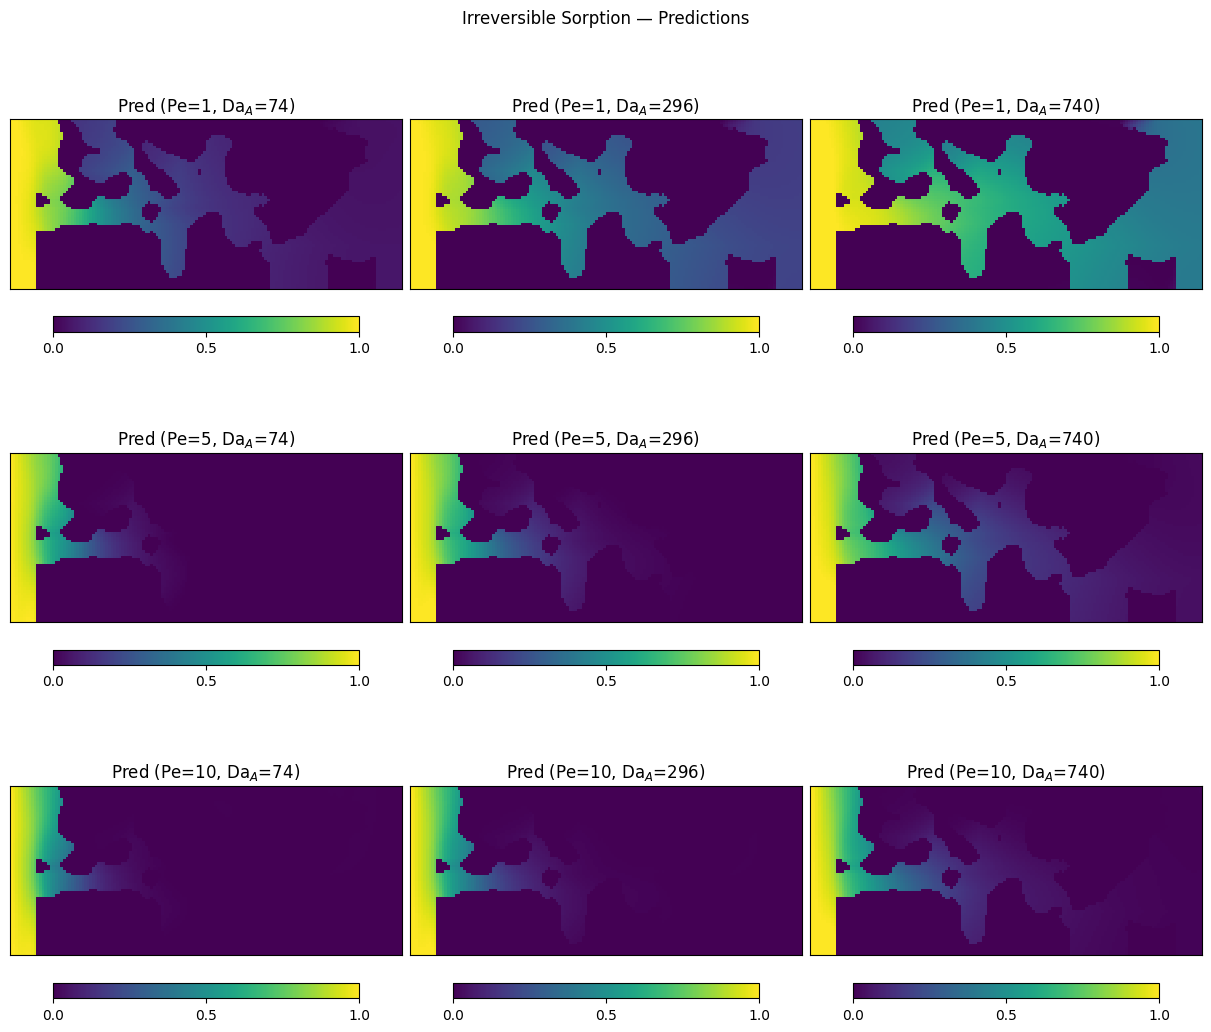

In [18]:
# ===============================
# 6) Visualization — 3x3 panel (rows=Pe, cols=Da_A), horizontal colorbars
# ===============================
# Arrange as Pe rows (1,5,10) and Da_A columns (74,296,740)
fig, axes = plt.subplots(len(PE_VALUES), len(DAA_VALUES), figsize=(12, 10), constrained_layout=True)

# Consistent scale (0..1); change if your outputs are unbounded
vmin, vmax = 0.0, 1.0

idx = 0
for r, pe in enumerate(PE_VALUES):
    for c, da in enumerate(DAA_VALUES):
        ax = axes[r, c] if axes.ndim == 2 else axes[max(r,c)]  # guard, but should be 2D
        im = ax.imshow(Y_pred[idx].numpy(), origin="lower", interpolation="nearest", vmin=vmin, vmax=vmax)
        ax.set_title(rf"Pred (Pe={pe:g}, $\mathrm{{Da}}_A$={da:g})")
        ax.set_xticks([]); ax.set_yticks([])
        cb = plt.colorbar(im, ax=ax, orientation="horizontal", fraction=0.06, pad=0.10)
        cb.set_ticks([0.0, 0.5, 1.0])
        idx += 1

plt.suptitle("Irreversible Sorption — Predictions", y=1.02)
plt.show()
